#Library Install and Dataset

In [1]:
import kagglehub
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")
print("Path to dataset files:", path)

100%|██████████| 734k/734k [00:00<00:00, 38.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/iammustafatz/diabetes-prediction-dataset/versions/1


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers,regularizers,models
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

#Dataset Assesing and Explore

In [3]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/iammustafatz/diabetes-prediction-dataset/versions/1/diabetes_prediction_dataset.csv')

In [4]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [7]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]
pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
gender,3
age,102
hypertension,2
heart_disease,2
smoking_history,6
bmi,4247
HbA1c_level,18
blood_glucose_level,18
diabetes,2


In [8]:
unique_values_in_column = df['smoking_history'].unique()
print(unique_values_in_column)

['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [9]:
df['diabetes'].value_counts()

,count
diabetes,
0,91500
1,8500


In [10]:
df_0 = df[df['diabetes'] == 0].sample(n=17000, random_state=1)
df_1 = df[df['diabetes'] == 1]

In [11]:
df_balanced = pd.concat([df_0, df_1], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)

In [12]:
gender_mapping = {'Male': 1, 'Female': 0}

smoking_mapping = {'never': 0,'No Info': 0, 'current': 1, 'former': 1, 'ever': 1, 'not current': 1}

In [13]:
df_balanced['gender'] = df_balanced['gender'].map(gender_mapping)

df_balanced['gender'] = df_balanced['gender'].replace('Other', 0)

df_balanced['smoking_history'] = df_balanced['smoking_history'].map(smoking_mapping)

In [14]:
df = df_balanced

In [15]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,45.0,0,0,0,41.07,6.6,160,1
1,1.0,44.0,0,0,0,32.84,4.5,140,0
2,1.0,23.0,0,0,1,21.28,6.5,100,0
3,1.0,80.0,0,0,0,27.32,8.8,155,1
4,1.0,59.0,0,0,1,31.67,6.5,160,1


In [16]:
df.isna().sum()

,0
gender,3
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [17]:
df = df.dropna(subset=['gender'])

In [18]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,45.0,0,0,0,41.07,6.6,160,1
1,1.0,44.0,0,0,0,32.84,4.5,140,0
2,1.0,23.0,0,0,1,21.28,6.5,100,0
3,1.0,80.0,0,0,0,27.32,8.8,155,1
4,1.0,59.0,0,0,1,31.67,6.5,160,1


In [19]:
df['diabetes'].value_counts()

,count
diabetes,
0,16997
1,8500


#Machine Learning Model

In [20]:
X = df.drop(columns=['diabetes']).values
y = df['diabetes'].values

In [21]:
X = X.astype(np.float32)
y = y.astype(np.int32)

In [22]:
seed = 39
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [23]:
  data = X
labels = y
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = (train_dataset
                 .shuffle(buffer_size=1000)
                 .batch(32)
                 .prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (test_dataset
                .batch(32)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [24]:
@register_keras_serializable()
def custom_relu(x):
    return K.maximum(0.0, x)

In [25]:
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    layers.Lambda(custom_relu),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    layers.Lambda(custom_relu),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    layers.Lambda(custom_relu),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.001)),
    layers.Lambda(custom_relu),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,481 (48.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer= optimizer,
              # loss=focal_loss(gamma=2., alpha=0.25),
              loss='BinaryFocalCrossentropy',
              metrics=['accuracy'])

In [27]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True
)

In [28]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [29]:
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.1
lr_scheduler = LearningRateScheduler(scheduler)

In [30]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [31]:
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=(test_dataset),
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/200
631/638 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5926 - loss: 0.4025
Epoch 1: val_accuracy improved from -inf to 0.83078, saving model to best_model.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5937 - loss: 0.4016 - val_accuracy: 0.8308 - val_loss: 0.2292 - learning_rate: 1.0000e-04
Epoch 2/200
635/638 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7857 - loss: 0.2533
Epoch 2: val_accuracy improved from 0.83078 to 0.85843, saving model to best_model.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7857 - loss: 0.2533 - val_accuracy: 0.8584 - val_loss: 0.2049 - learning_rate: 1.0000e-04
Epoch 3/200
630/638 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8100 - loss: 0.2283
Epoch 3: val_accuracy improved from 0.85843 to 0.87176, saving model to best_model.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8102 - loss: 0.2282 - val_accuracy: 0.8718 - val_loss: 0.1913 - learning_rate: 1.0000e-04
Epoch 4/200
633/638 ━━━━━━━━━━━━━━━━━━━━

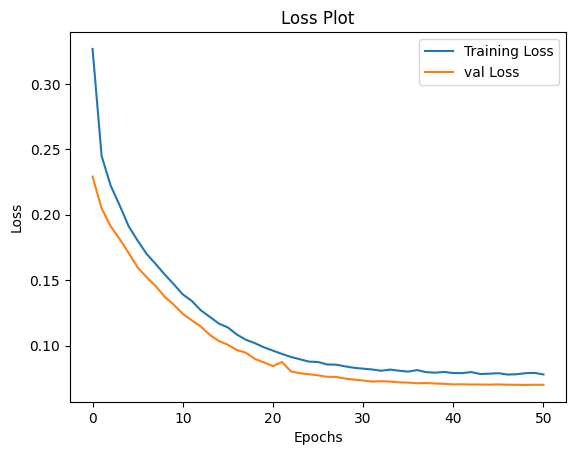

In [32]:
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

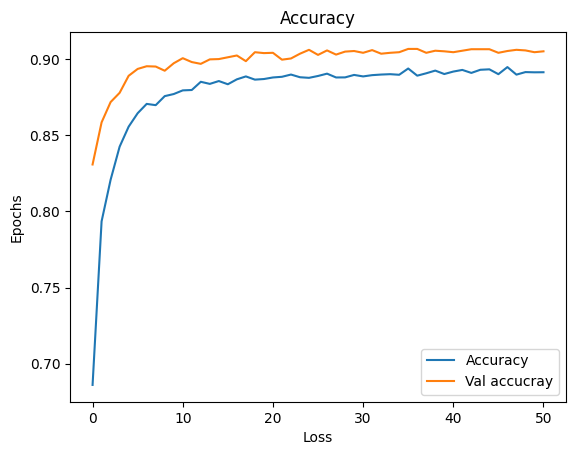

In [33]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val accucray')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9034 - loss: 0.0725
Test accuracy: 0.9066666960716248
Test Loss: 0.07182972878217697


In [35]:
risk_percentage = model.predict(X_test) * 100
print(f"Resiko Diabetes (dalam %):", risk_percentage)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Resiko Diabetes (dalam %): [[47.572094]
 [40.820446]
 [23.373478]
 ...
 [21.484692]
 [76.77225 ]
 [46.476746]]


In [36]:
df.tail()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
25495,1.0,39.0,0,0,0,36.31,4.8,126,0
25496,1.0,44.0,0,0,1,27.32,5.7,145,1
25497,1.0,43.0,0,0,0,39.22,6.1,100,0
25498,1.0,35.0,0,0,1,31.96,6.5,158,0
25499,1.0,19.0,0,0,0,19.49,5.7,159,0


In [37]:
df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,25497.000000,25497.000000,25497.000000,25497.000000,25497.000000,25497.000000,25497.000000,25497.000000,25497.000000
mean,0.429854,47.069710,0.121779,0.069734,0.332784,28.603499,5.908248,153.509079,0.333373
std,0.495065,22.255996,0.327037,0.254703,0.471219,7.191621,1.241810,52.401753,0.471428
min,0.000000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,30.000000,0.000000,0.000000,0.000000,24.920000,5.000000,126.000000,0.000000
50%,0.000000,50.000000,0.000000,0.000000,0.000000,27.320000,6.000000,145.000000,0.000000
75%,1.000000,65.000000,0.000000,0.000000,1.000000,31.580000,6.500000,160.000000,1.000000
max,1.000000,80.000000,1.000000,1.000000,1.000000,88.720000,9.000000,300.000000,1.000000


In [38]:
df['diabetes'].value_counts()

,count
diabetes,
0,16997
1,8500


#TRY INPUTS

In [39]:
input_array = np.array([[1, 59, 0, 0, 1, 31.67, 6.5, 160]])
predicted_risk = model.predict(input_array)
print(f"Resiko terkena diabetes anda adalah: {predicted_risk[0][0]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Resiko terkena diabetes anda adalah: 0.51%


In [40]:
input_array = np.array([[1.0,	80.0,	0,	0,	0,	27.32,	8.8, 155]])
predicted_risk = model.predict(input_array) * 100
print(f"Resiko terkena diabetes anda adalah: {predicted_risk[0][0]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Resiko terkena diabetes anda adalah: 95.53%


In [41]:
input_array = np.array([[1.0,	43.0,	0,	0,	0,	39.22,	6.1,	89	]])
predicted_risk = model.predict(input_array) * 100
print(f"Resiko terkena diabetes anda adalah: {predicted_risk[0][0]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Resiko terkena diabetes anda adalah: 8.19%


In [42]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path)
!tensorflowjs_converter --input_format=keras {saved_model_path} ./
!zip MODEL_DIABETES.zip *.bin model.json

/bin/bash: line 1: tensorflowjs_converter: command not found
	zip warning: name not matched: *.bin
	zip warning: name not matched: model.json

zip error: Nothing to do! (MODEL_DIABETES.zip)


In [43]:
df.to_csv('updated_diabetes_prediction.csv', index=False)